#Dog Breed Prediction by using Transfer Learning

**Upload the dataset into google colab**

The dataset is taken from one of [Udacity project's dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).

The dataset contains 120 classes of dog breeds. Our task is to predict each dog's  breed. 

Example of the dog image in the dataset is ![dog](https://github.com/FairozaAmira/DeepLearning/blob/master/project-dog-classification/images/Brittany_02625.jpg?raw=true) which is classified as Brittany.

In [1]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

--2019-07-27 07:44:29--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.48
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.2’

dogImages.zip.2     100%[===================>]   1.05G  26.9MB/s    in 41s     

2019-07-27 07:45:11 (26.1 MB/s) - ‘dogImages.zip.2’ saved [1132023110/1132023110]



In [2]:
#unzip the dataset
!unzip 'dogImages.zip'

Archive:  dogImages.zip
replace dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
#check the directory

!ls "../content/dogImages"

test  train  valid


**Get the images and targets of the image for classification**

In [4]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../content/dogImages/train')
valid_files, valid_targets = load_dataset('../content/dogImages/valid')
test_files, test_targets = load_dataset('../content/dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../content/dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


**Detect dogs's breed by using Pre-trained Model without any modification at any layer**

In [5]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

W0727 07:45:50.513424 140076657149824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 07:45:50.527477 140076657149824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 07:45:50.533711 140076657149824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0727 07:45:50.560802 140076657149824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0727 07:45:50.563966

**Preprocess the data to tensor**

In [0]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

**Decode the predictions**

In [0]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

**Detect the dog by using pretrained model just now**

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [9]:
dog_files_short = train_files[:100]
sum_dog_files = 0
for item in dog_files_short:
    detection = dog_detector(item)
    if detection == True:
        sum_dog_files += 1
            
print(sum_dog_files/len(dog_files_short))

1.0


**Data preprocessing for Keras**

In [10]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 147.49it/s]


###Transfer Learning with the modification at the end of the layer.

The model can be changed to any appropriate model by referring to [Keras documentation](https://keras.io/applications/).

In [11]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.summary()

W0727 07:47:22.037449 140076657149824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

**Replace the final layer with two hidden layers and a dropout layer. The final hidden layer should have the number of outputs.**

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.optimizers import Adam

for layer in base.layers[:-1]:
    layer.trainable = False

x = base.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(133, activation="softmax")(x)

model = Model(input = base.input, output = predictions)

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

W0727 07:47:34.465386 140076657149824 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
W0727 07:47:34.530011 140076657149824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

**Data augmentation to avoid overfitting**

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    featurewise_center=True, 
    samplewise_center=True,
    width_shift_range=0.2,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.2,# randomly shift images vertically (10% of total height)
    rotation_range = 20,
    horizontal_flip=True,
    vertical_flip = True,
    shear_range = 0.1) 

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_train.fit(valid_tensors)

**Training the data**

In [14]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau   

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 20
batch_size = 128

### Do NOT modify the code below this line.

checkpointer = [
    ReduceLROnPlateau(monitor='val_loss', 
                      patience=2, 
                      verbose=1,
                      factor=0.5,
                      min_lr = 0.00001,
                      cooldown=0),
    ModelCheckpoint('model_best.hdf5',
        monitor='val_acc', 
        save_best_only=True, 
        mode='max',
        verbose=1)
]

hist = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=checkpointer, verbose=1, shuffle=True)

W0727 07:47:47.002831 140076657149824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 30s 4ms/step - loss: 5.7453 - acc: 0.0895 - val_loss: 3.0063 - val_acc: 0.3713

Epoch 00001: val_acc improved from -inf to 0.37126, saving model to model_best.hdf5
Epoch 2/20
6680/6680 [==============================] - 20s 3ms/step - loss: 3.6766 - acc: 0.2135 - val_loss: 2.5272 - val_acc: 0.4934

Epoch 00002: val_acc improved from 0.37126 to 0.49341, saving model to model_best.hdf5
Epoch 3/20
6680/6680 [==============================] - 20s 3ms/step - loss: 3.0858 - acc: 0.3061 - val_loss: 1.7972 - val_acc: 0.5916

Epoch 00003: val_acc improved from 0.49341 to 0.59162, saving model to model_best.hdf5
Epoch 4/20
6680/6680 [==============================] - 19s 3ms/step - loss: 2.6658 - acc: 0.3656 - val_loss: 1.6400 - val_acc: 0.6251

Epoch 00004: val_acc improved from 0.59162 to 0.62515, saving model to model_best.hdf5
Epoch 5/20
6680/6680 [==============================] - 19s 3ms/

**Plot the train accuracy and validation accuracy**

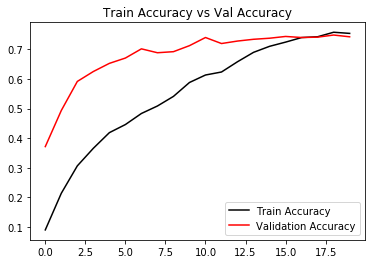

In [15]:
import matplotlib.pyplot as plt

plt.title('Train Accuracy vs Val Accuracy')
plt.plot(hist.history['acc'], label='Train Accuracy', color='black')
plt.plot(hist.history['val_acc'], label='Validation Accuracy', color='red')
plt.legend()
plt.show()

**Get the validation data accuracy**

In [16]:
from keras.models import load_model

model = load_model('model_best.hdf5')
score = model.evaluate(valid_tensors, valid_targets, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Validation accuracy: %.4f%%' % accuracy)

Validation accuracy: 74.8503%


**Get the test accuracy**

In [17]:
score, acc = model.evaluate(test_tensors, test_targets,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


836/836 [==============================] - 4s 5ms/step
Test score: 1.7735420288651753
Test accuracy: 0.6901913892709467
